In [157]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
import geopandas as gpd
import geodatasets

C:\Users\Samsung\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [5]:
file_path = 'aviation-accidents.csv'

df = pd.read_csv(file_path)

df.head()

,date,type,registration,operator,fatalities,location,country,cat,year
0,date unk.,Antonov An-12B,T-1206,Indonesian AF,NaN,NaN,Unknown country,U1,unknown
1,date unk.,Antonov An-12B,T-1204,Indonesian AF,NaN,NaN,Unknown country,U1,unknown
2,date unk.,Antonov An-12B,T-1201,Indonesian AF,NaN,NaN,Unknown country,U1,unknown
3,date unk.,Antonov An-12BK,NaN,Soviet AF,NaN,Tiksi Airport (IKS),Russia,A1,unknown
4,date unk.,Antonov An-12BP,CCCP-11815,Soviet AF,0,Massawa Airport ...,Eritrea,A1,unknown


## Data Preliminary Exploration

In [10]:
df.dtypes

date            object
type            object
registration    object
operator        object
fatalities      object
location        object
country         object
cat             object
year            object
dtype: object

In [12]:
df.shape

(23967, 9)

In [14]:
df.isna().sum()

date               0
type               0
registration    1548
operator           4
fatalities      3938
location         948
country            0
cat                0
year               0
dtype: int64

In [16]:
df.isna().sum()/df.shape[0]

date            0.000000
type            0.000000
registration    0.064589
operator        0.000167
fatalities      0.164309
location        0.039554
country         0.000000
cat             0.000000
year            0.000000
dtype: float64

In [22]:
for col in df.columns:
  print(df[col].value_counts())
  print('\n')

date
10-MAY-1940    171
date unk.       61
24-MAR-1945     50
06-JUN-1944     41
17-SEP-1944     35
              ... 
04-MAY-1971      1
06-MAY-1971      1
07-MAY-1971      1
08-MAY-1971      1
15-MAY-2023      1
Name: count, Length: 15079, dtype: int64


type
Douglas C-47A (DC-3)        1916
Douglas C-47 (DC-3)          669
Douglas C-47B (DC-3)         592
Curtiss C-46A                564
Junkers Ju-52/3m             471
                            ... 
Boeing 737-3Z6                 1
Boeing 747-230B (M)            1
Lockheed P2V-2N Neptune        1
Ilyushin Il-76MD Adnan-1       1
Boeing 777-233LR               1
Name: count, Length: 3201, dtype: int64


registration
LZ-...     13
-          11
unreg.      6
39          5
48          4
           ..
52-5881     1
HJ250       1
11073       1
45-879      1
D-CGFQ      1
Name: count, Length: 21962, dtype: int64


operator
USAAF                          2604
USAF                           1120
RAF                             920
US Nav

In [24]:
df.duplicated().sum()

115

In [26]:
df [ (df['type'] == 'Junkers Ju-52/3m') & (df['country'] == 'Norway') & (df['date'] == '13-APR-1940')]

,date,type,registration,operator,fatalities,location,country,cat,year
540,13-APR-1940,Junkers Ju-52/3m,NG+BU,German AF,NaN,"Froysjoen, Berle...",Norway,C1,1940
541,13-APR-1940,Junkers Ju-52/3m,NaN,German AF,NaN,"Gangsoya, Sogn o...",Norway,A1,1940
542,13-APR-1940,Junkers Ju-52/3m,NaN,German AF,NaN,"Gangsoya, Sogn o...",Norway,A1,1940


In [28]:
df.iloc[6440:6445, :]

,date,type,registration,operator,fatalities,location,country,cat,year
6440,24-MAR-1950,Douglas DC-3,NaN,CSA,0,Erding Air Base,Germany,H2,1950
6441,24-MAR-1950,Douglas DC-3,NaN,CSA,0,Erding Air Base,Germany,H2,1950
6442,24-MAR-1950,Douglas DC-3,NaN,CSA,0,Erding Air Base,Germany,H2,1950
6443,25-MAR-1950,Douglas C-47A (DC-3),TC-BAL,DHY,15,near Ankara-Etimesgut...,Turkey,A1,1950
6444,25-MAR-1950,Lockheed 414-08 Hudson IVA,VH-BDN,"Fawcett Aviation Service, op.for Mandated Airines",1+ 2,Lae Airfield,P.N. Guinea,A1,1950


In [30]:
df.drop_duplicates(inplace=True)

In [32]:
df.shape

(23852, 9)

## Columns Manipulation and Cleaning

In [37]:
print('day date missing: ', df['date'].str.slice(0,3).str.contains(r'\?\?-').sum())
print('month date missing: ', df['date'].str.slice(2,7).str.contains(r'-\?\?\?-').sum())
print('year date missing: ', df['date'].str.slice(start=6).str.contains(r'-\?\?\?\?').sum())
print('date any missing: ', df['date'].str.contains(r'\?').sum())
print('date "date unknown": ', df['date'].str.contains('date unk.').sum())

day date missing:  487
month date missing:  233
year date missing:  0
date any missing:  487
date "date unknown":  61


In [39]:
df[~df['year'].str.isdigit()].shape

(61, 9)

In [41]:
df["year"] =pd.to_numeric(df["year"], errors="coerce")

In [43]:
month_converter = {"JAN": 1 , "FEB": 2 , "MAR": 3, "APR": 4, "MAY": 5, "JUN": 6, "JUL": 7, "AUG": 8, "SEP": 9, "OCT": 10, "NOV": 11, "DEC": 12}
df["month"] = df["date"].str.split("-").str[1]


def convert_month(month_str):
  if month_str in month_converter.keys():
    return month_converter[month_str]
  else:
    return np.nan

df["month"] = df["month"].apply(convert_month)

In [45]:
df["day"] = df["date"].str.split("-").str[0]

def convert_day(day_str):
  if day_str in ("date unk.", "??"):
    return np.nan
  else:
    return int(day_str)

df["day"] = df["day"].apply(convert_day)

In [47]:
df["date_cleared"] = pd.to_datetime(df["date"], format="%d-%b-%Y", errors="coerce")

In [49]:
df["week_day"] = df["date_cleared"].dt.day_name()

In [51]:
df.head()

,date,type,registration,operator,fatalities,location,country,cat,year,month,day,date_cleared,week_day
0,date unk.,Antonov An-12B,T-1206,Indonesian AF,NaN,NaN,Unknown country,U1,NaN,NaN,NaN,NaT,NaN
1,date unk.,Antonov An-12B,T-1204,Indonesian AF,NaN,NaN,Unknown country,U1,NaN,NaN,NaN,NaT,NaN
2,date unk.,Antonov An-12B,T-1201,Indonesian AF,NaN,NaN,Unknown country,U1,NaN,NaN,NaN,NaT,NaN
3,date unk.,Antonov An-12BK,NaN,Soviet AF,NaN,Tiksi Airport (IKS),Russia,A1,NaN,NaN,NaN,NaT,NaN
4,date unk.,Antonov An-12BP,CCCP-11815,Soviet AF,0,Massawa Airport ...,Eritrea,A1,NaN,NaN,NaN,NaT,NaN


In [53]:
df['fatalities'] = pd.to_numeric(df['fatalities'], errors='coerce')

In [55]:
df["cat_type"] = df["cat"].str[0]
df["cat_gravity"] = df["cat"].str[1]

In [57]:
cat_converter = {"A" : "Accident",
                 "I" : "Incident",
                 "H" : "Hijacking",
                 "C" : "Criminal Occurrence",
                 "O": "Other Occurrence",
                 "U": "Unknown Occurrence",
                 "1": "Hull-Loss",
                 "2": "Repairable Damage"
                 }


def convert_cat_type(cat_t_g):
    return cat_converter[cat_t_g]

df["cat_type"] = df["cat_type"].apply(convert_cat_type)
df["cat_gravity"] = df["cat_gravity"].apply(convert_cat_type)

In [59]:
reg_filter = (
    (df["registration"].str.contains("fake reg.")) | 
    (df["registration"].str.contains("false reg.")) | 
    (df["registration"].str.contains("no reg.")) | 
    (df["registration"].str.contains("unreg"))
    )

reg_filter_delete =  (df["registration"].str.contains("fake reg.")) | (df["registration"].str.contains("false reg."))
df = df.drop(df[reg_filter_delete].index)

df["registration"] = ["Not available" if value in ("no reg.", "unreg.") else value for value in df["registration"]]

In [61]:
df["registration"] = df["registration"].fillna("Not available")

In [63]:
df["operator"] = df["operator"].fillna("Not available")

df["operator"] = ["Not available" if value=="Unknown" else value for value in df["operator"]]

In [65]:
df["location"] = df["location"].fillna("Not available")

In [67]:
df["type"] = ["Not available" if value in ("unkonwn.", "unknown jetliner") else value for value in df["type"]]

In [69]:
df["country"] = ["Not available" if value in ("?", "Unknown country") else value for value in df["country"]]

In [71]:
df["location"] = df["location"].fillna("Not available")

In [73]:
missing_per_column = {}
for column in df.columns:
  nulli = df[column].isnull().sum()
  if df[column].dtype == "object":
    not_available = df[column].str.contains("Not available").sum()
  tot_missing = nulli + not_available
  missing_per_column[column] = (f"tot missing : {tot_missing} ({tot_missing / df.shape[0] * 100:.2f}%)", f"null: {nulli}, not_available: {not_available}")
  not_available = 0
  nulli = 0
    
print(df.shape[0])
missing_per_column

23849


{'date': ('tot missing : 0 (0.00%)', 'null: 0, not_available: 0'),
 'type': ('tot missing : 1 (0.00%)', 'null: 0, not_available: 1'),
 'registration': ('tot missing : 1441 (6.04%)',
  'null: 0, not_available: 1441'),
 'operator': ('tot missing : 189 (0.79%)', 'null: 0, not_available: 189'),
 'fatalities': ('tot missing : 4186 (17.55%)', 'null: 4186, not_available: 0'),
 'location': ('tot missing : 932 (3.91%)', 'null: 0, not_available: 932'),
 'country': ('tot missing : 857 (3.59%)', 'null: 0, not_available: 857'),
 'cat': ('tot missing : 0 (0.00%)', 'null: 0, not_available: 0'),
 'year': ('tot missing : 61 (0.26%)', 'null: 61, not_available: 0'),
 'month': ('tot missing : 295 (1.24%)', 'null: 295, not_available: 0'),
 'day': ('tot missing : 548 (2.30%)', 'null: 548, not_available: 0'),
 'date_cleared': ('tot missing : 549 (2.30%)', 'null: 549, not_available: 0'),
 'week_day': ('tot missing : 549 (2.30%)', 'null: 549, not_available: 0'),
 'cat_type': ('tot missing : 0 (0.00%)', 'null: 

In [75]:
df.dtypes

date                    object
type                    object
registration            object
operator                object
fatalities             float64
location                object
country                 object
cat                     object
year                   float64
month                  float64
day                    float64
date_cleared    datetime64[ns]
week_day                object
cat_type                object
cat_gravity             object
dtype: object

In [79]:
df['fatalities'] = df['fatalities'].fillna(df['fatalities'].median())

In [81]:
duplicates_mask = df[['date', 'type', 'operator', 'fatalities', 'location',
       'country', 'cat', 'year', 'month', 'day', 'date_cleared', 'week_day',
       'cat_type', 'cat_gravity']].duplicated()

df[duplicates_mask] = df[duplicates_mask].drop_duplicates()

## Exploratory data analysis (EDA) e Deliverables

In [86]:
sns.set_palette("Set2")

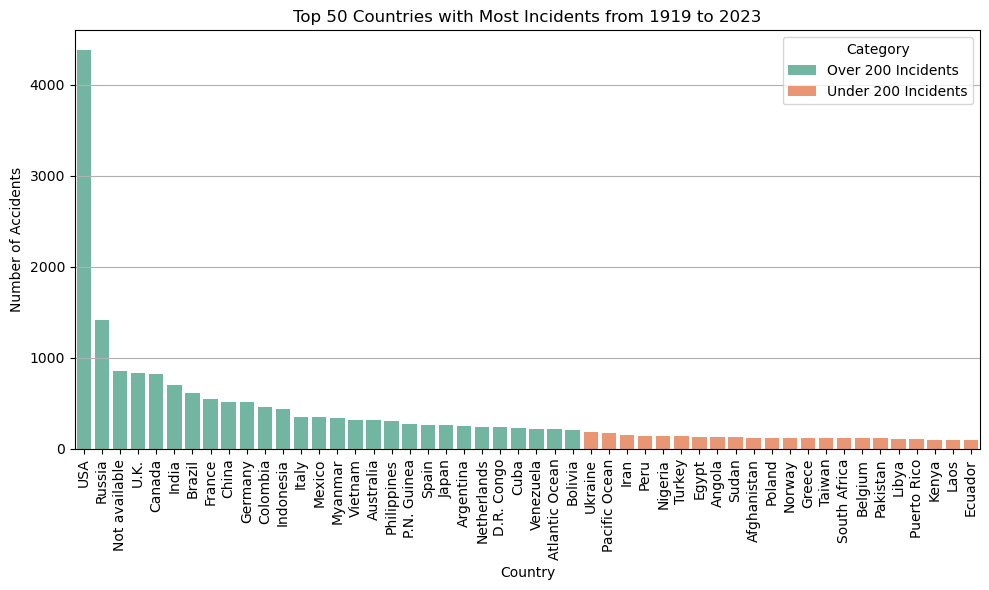

In [88]:
coutry_50_most_accidents = pd.DataFrame(df['country'].value_counts().sort_values(ascending=False)[:50]).reset_index()
coutry_50_most_accidents['Category'] = np.where(coutry_50_most_accidents['count']>200,
                                                'Over 200 Incidents', 'Under 200 Incidents')

plt.figure(figsize=(10, 6))

sns.barplot(data=coutry_50_most_accidents, x='country', y='count', hue='Category')
plt.title('Top 50 Countries with Most Incidents from 1919 to 2023')
plt.xlabel('Country')
plt.ylabel('Number of Accidents')
plt.grid(axis='y')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

Country with the most aviation incidents from 1919 has been the USA, followed by Russia.
There are also a significant number of incidents in the dataset whise location is unknown.

In [91]:
week_days_df = df['week_day'].value_counts().sort_values(ascending=False)
week_days_df

week_day
Friday       3608
Thursday     3513
Wednesday    3491
Tuesday      3443
Monday       3308
Saturday     3184
Sunday       2752
Name: count, dtype: int64

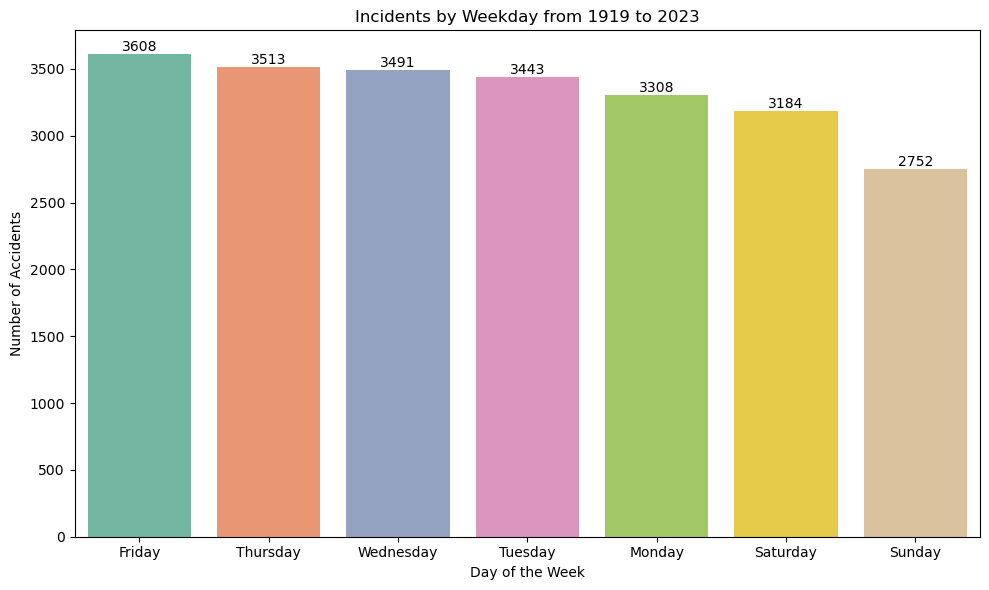

In [93]:
week_days_df = df['week_day'].value_counts().sort_values(ascending=False).reset_index()
week_days_df.columns = ['week_day', 'count']

plt.figure(figsize=(10, 6))

sns.barplot(data=week_days_df, x='week_day', y='count', hue='week_day')
plt.title('Incidents by Weekday from 1919 to 2023')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Accidents')
for i in enumerate(week_days_df['count']):
  plt.text(i[0], i[1], str(i[1]), ha='center', va='bottom')
# plt.grid(axis='y')
# plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [95]:
week_days_df_4 = df.groupby(['week_day', 'year']).agg('count')['date'].reset_index()
week_days_df_4.columns = ['week_day', 'year', 'count']

def hyst_period(year):
  if year<= 1945:
    return '1919-1945'
  elif year<= 1971:
    return '1946-1971'
  elif year<= 1997:
    return '1972-1997'
  else:
    return '1998-2023'
week_days_df_4['period'] = week_days_df_4['year'].apply(hyst_period)
week_days_df_4 = week_days_df_4.drop('year', axis=1)
week_days_df_4 = week_days_df_4.groupby(['week_day', 'period']).agg('sum').reset_index()
week_days_df_4.columns = ['week_day', 'period', 'count']

ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

week_days_df_4['week_day'] = pd.Categorical(week_days_df_4['week_day'], categories=ordered_days, ordered=True)
week_days_df_4 = week_days_df_4.sort_values('week_day')

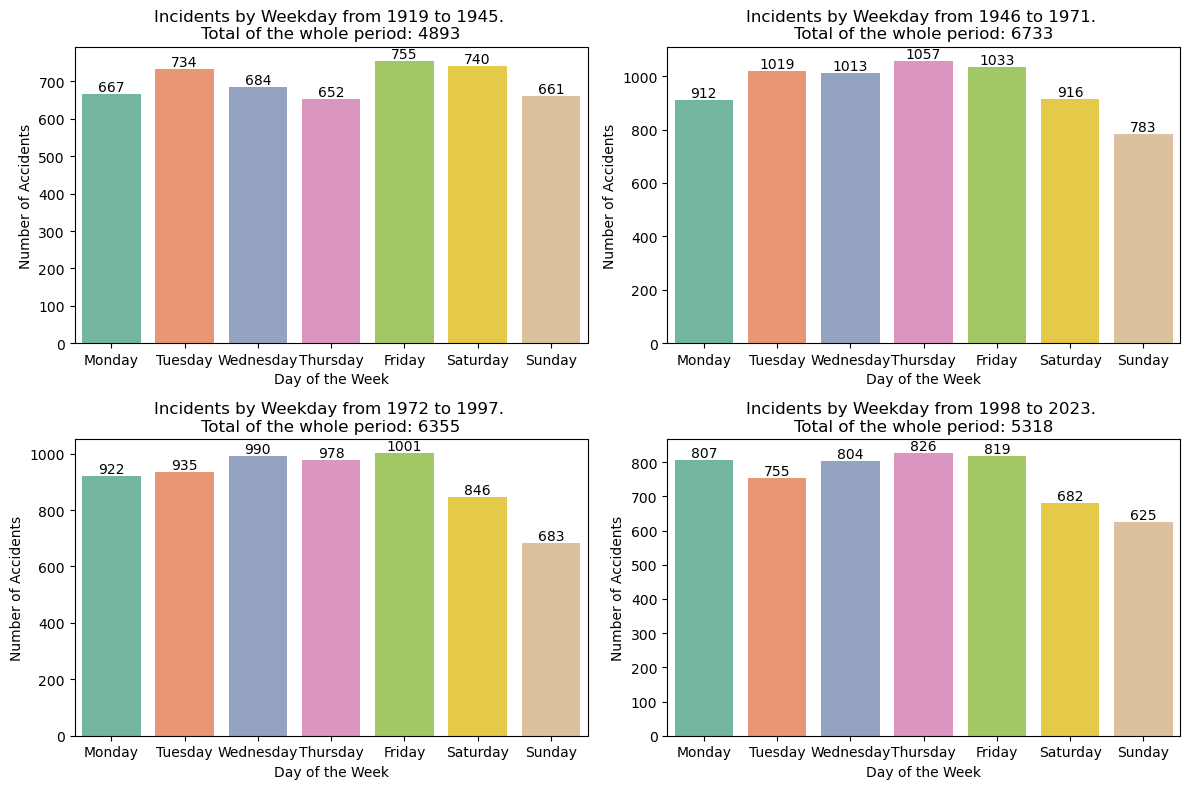

In [97]:
fig, axs = plt.subplots(2, 2,  figsize=(12,8))


ax_1 = axs[0, 0]
ax_2 = axs[0, 1]
ax_3 = axs[1, 0]
ax_4 = axs[1, 1]

p_1919_1945 = week_days_df_4[week_days_df_4['period'] == '1919-1945']
sns.barplot(data=p_1919_1945, x='week_day', y='count', hue='week_day', ax=ax_1)
ax_1.set_title(f'Incidents by Weekday from 1919 to 1945. \nTotal of the whole period: {p_1919_1945["count"].sum()}')
ax_1.set_xlabel('Day of the Week')
ax_1.set_ylabel('Number of Accidents')
for i in enumerate(p_1919_1945['count']):
  ax_1.text(i[0], i[1], str(i[1]), ha='center', va='bottom')


p_1946_1971 = week_days_df_4[week_days_df_4['period'] == '1946-1971']
sns.barplot(data=p_1946_1971, x='week_day', y='count', hue='week_day', ax=ax_2)
ax_2.set_title(f'Incidents by Weekday from 1946 to 1971. \nTotal of the whole period: {p_1946_1971["count"].sum()}')
ax_2.set_xlabel('Day of the Week')
ax_2.set_ylabel('Number of Accidents')
for i in enumerate(p_1946_1971['count']):
  ax_2.text(i[0], i[1], str(i[1]), ha='center', va='bottom')


p_1972_1997 = week_days_df_4[week_days_df_4['period'] == '1972-1997']
sns.barplot(data=p_1972_1997, x='week_day', y='count', hue='week_day', ax=ax_3)
ax_3.set_title(f'Incidents by Weekday from 1972 to 1997. \nTotal of the whole period: {p_1972_1997["count"].sum()}')
ax_3.set_xlabel('Day of the Week')
ax_3.set_ylabel('Number of Accidents')
for i in enumerate(p_1972_1997['count']):
  ax_3.text(i[0], i[1], str(i[1]), ha='center', va='bottom')


p_1998_2023 = week_days_df_4[week_days_df_4['period'] == '1998-2023']
sns.barplot(data=p_1998_2023, x='week_day', y='count', hue='week_day', ax=ax_4)
ax_4.set_title(f'Incidents by Weekday from 1998 to 2023. \nTotal of the whole period: {p_1998_2023["count"].sum()}')
ax_4.set_xlabel('Day of the Week')
ax_4.set_ylabel('Number of Accidents')
for i in enumerate(p_1998_2023['count']):
  ax_4.text(i[0], i[1], str(i[1]), ha='center', va='bottom')


plt.tight_layout()
plt.show()


The day of the week with the most accidents in the last 104 years has been Friday.
Even breaking down the century into 4 subgroups, Friday remains one of the most inauspicious days.

In [100]:
month_df = df.groupby(['month', 'year']).agg('count')['date'].reset_index()
month_df.columns = ['month', 'year', 'count']

def hyst_period(year):
  if year<= 1945:
    return '1919-1945'
  elif year<= 1971:
    return '1946-1971'
  elif year<= 1997:
    return '1972-1997'
  else:
    return '1998-2023'

month_df['period'] = month_df['year'].apply(hyst_period)
month_df = month_df.drop('year', axis=1)
month_df = month_df.groupby(['month', 'period']).agg('sum').reset_index()
month_df.columns = ['month', 'period', 'count']

month_df = month_df.sort_values('month')

months_conv = ["JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]
month_df['month'] = month_df['month'].map(lambda mon: months_conv[int(mon)-1])


C:\Users\Samsung\anaconda3\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


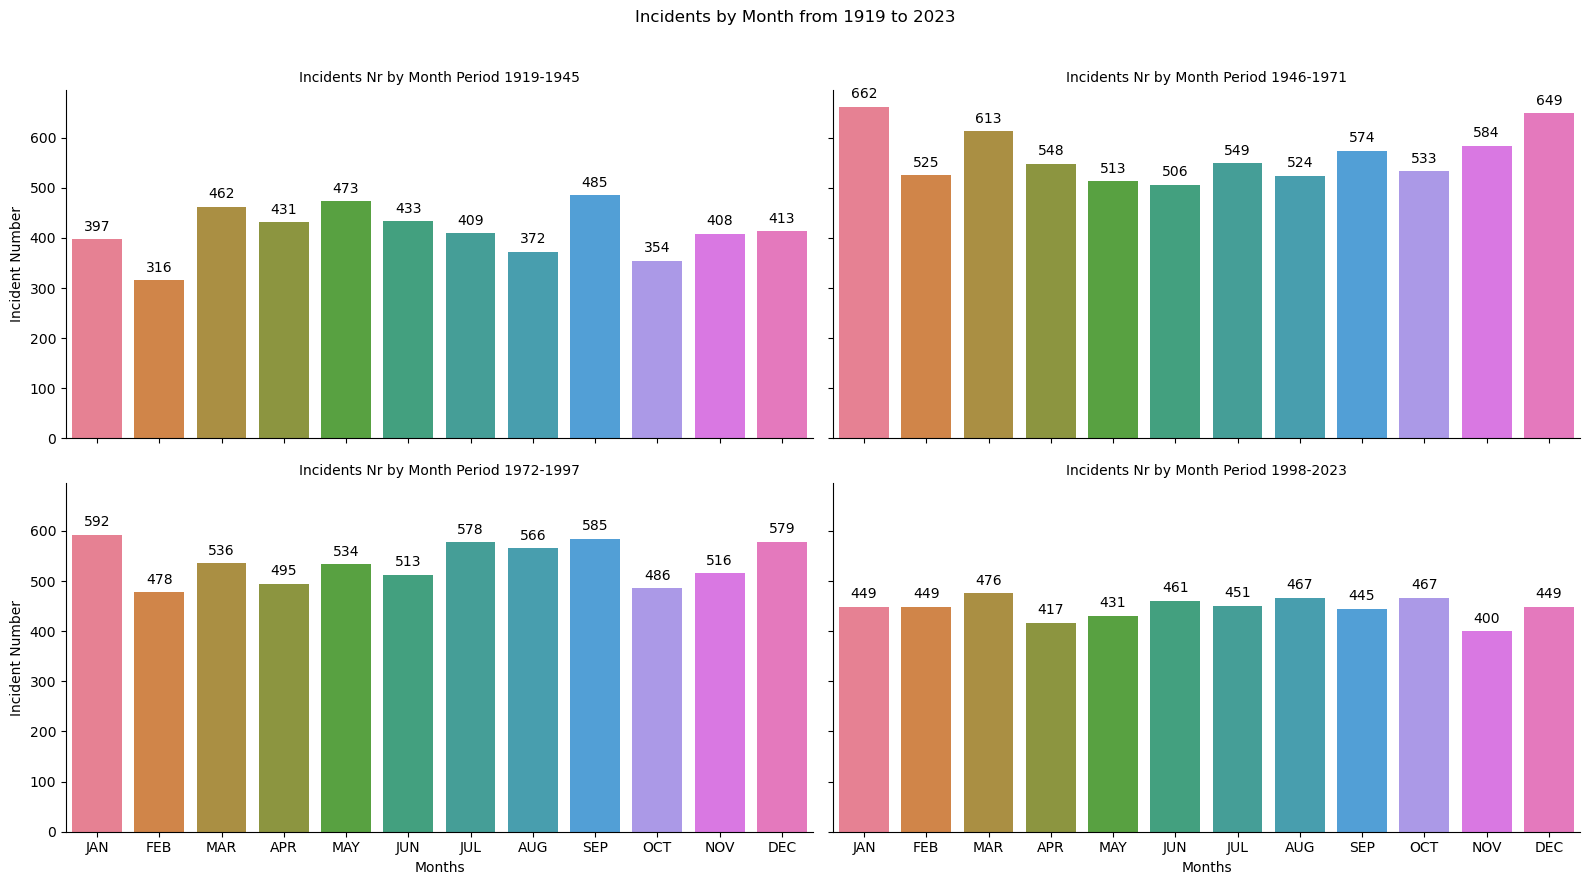

In [102]:
mon_4 = sns.FacetGrid(month_df, col='period', hue='month', col_wrap=2, height=4, aspect=2)

mon_4.map(sns.barplot, 'month', 'count')



mon_4.set_axis_labels('Months', 'Incident Number')
mon_4.set_titles(col_template='Incidents Nr by Month Period {col_name}', size=10)
for ax in mon_4.axes.flat:
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9),
                    textcoords='offset points')

plt.subplots_adjust(top=1)
mon_4.fig.suptitle('Incidents by Month from 1919 to 2023', fontsize=12, y=1.1)

plt.show()

In [104]:
df['month'].unique()

array([nan,  8.,  2.,  6., 12.,  1.,  3.,  9.,  4.,  5.,  7., 10., 11.])

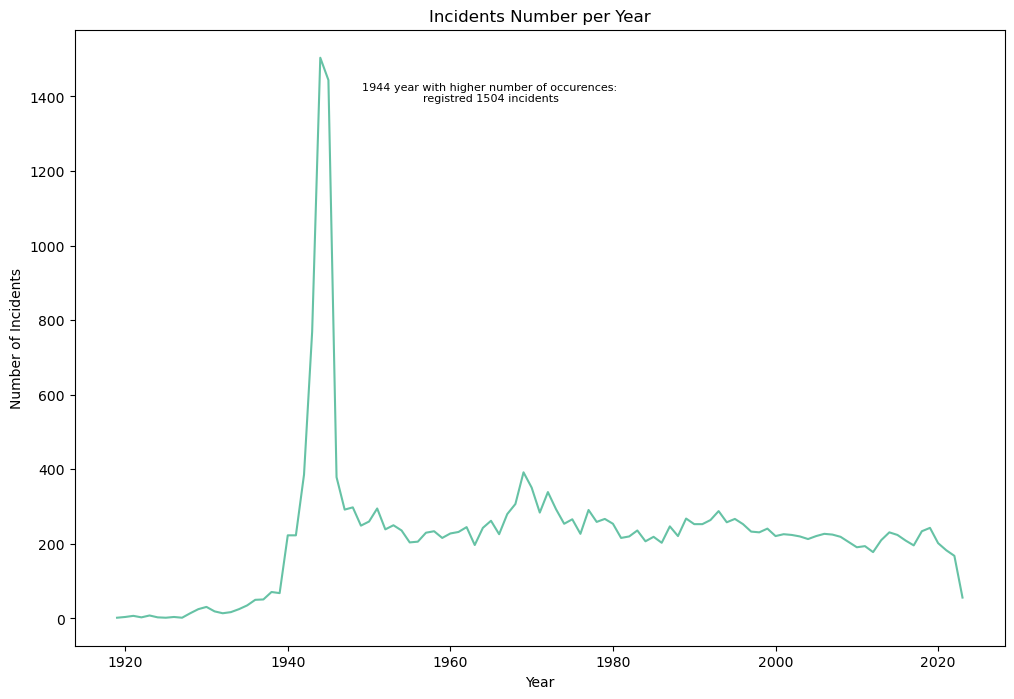

In [108]:
plt.figure(figsize=(12,8))

incid_per_year = df.groupby('year').size().reset_index(name='count')

worst_year = int(incid_per_year.loc[incid_per_year['count'].idxmax(), 'year'])
worst_count = int(incid_per_year['count'].max())

sns.lineplot(data=incid_per_year, x='year', y='count')
plt.title('Incidents Number per Year')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')

plt.text(x=1965, y=1410, s=(f'{worst_year} year with higher number of occurences: \nregistred {worst_count} incidents'), fontsize=8, color='black', ha='center', va='center')

plt.show()

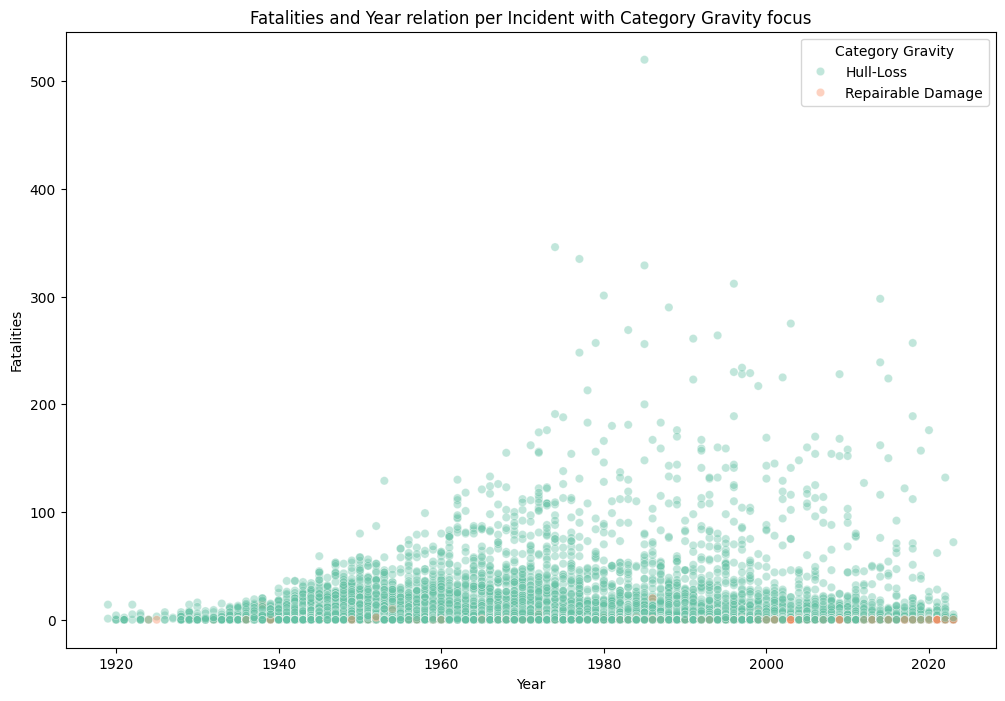

In [282]:
plt.figure(figsize=(12,8))

sns.scatterplot(data=df, x='year', y='fatalities', hue='cat_gravity', alpha=0.4)
plt.title('Fatalities and Year relation per Incident with Category Gravity focus')
plt.xlabel('Year')
plt.ylabel('Fatalities')
plt.legend(title='Category Gravity')

plt.show()

Although there is no clear direction among the variables, the graph shows that:
1. the greatest number of incidents caused between zero and 100 deaths
2. the number of victims per single incident increased over the years
3. almost all incidents resulted in the loss of the vehicle involved

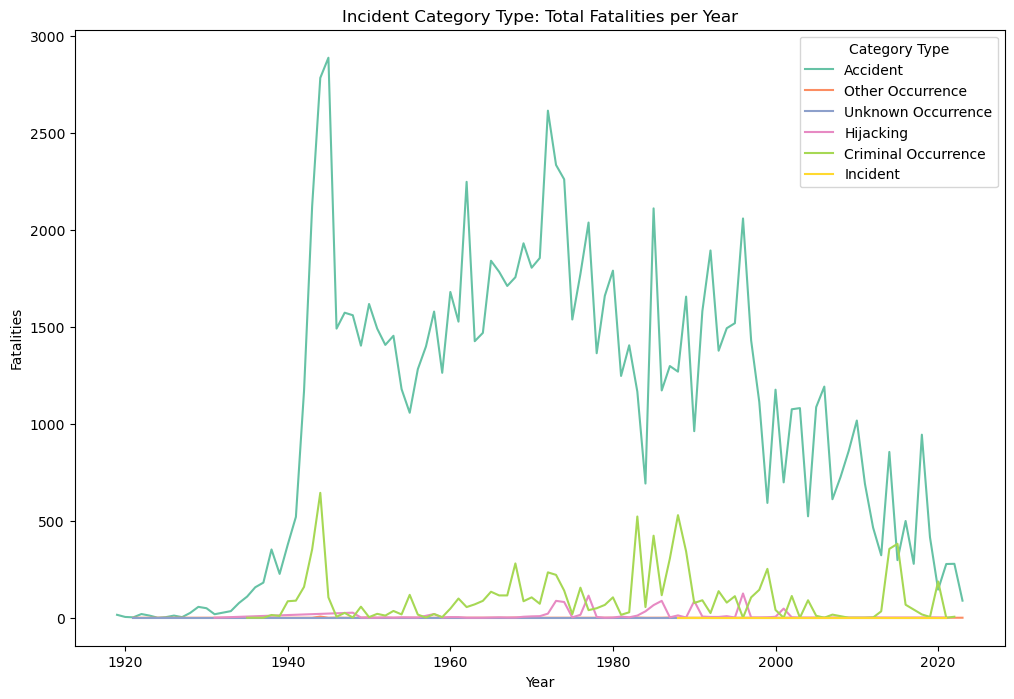

In [111]:
cat_over_time = df.groupby(['year', 'cat_type'])['fatalities'].sum().reset_index()


plt.figure(figsize=(12,8))

sns.lineplot(data=cat_over_time, x='year', y='fatalities', hue='cat_type', errorbar=None)
plt.title('Incident Category Type: Total Fatalities per Year')
plt.xlabel('Year')
plt.ylabel('Fatalities')
plt.legend(title='Category Type')


plt.show()

In [113]:
cat_over_time_2 = df.groupby(['year', 'cat_type'])[['fatalities', 'cat']].agg(total_fatalities=('fatalities', 'sum'),
    mean_fatalities=('fatalities', 'mean'),
    count_incidents=('cat', 'count')).reset_index()

In [115]:
cat_over_time_3 = df.groupby([ 'cat_type'])[['fatalities', 'cat']].agg(total_fatalities=('fatalities', 'sum'),
    mean_fatalities=('fatalities', 'mean'),
    count_incidents=('cat', 'count')).reset_index()

cat_over_time_3

,cat_type,total_fatalities,mean_fatalities,count_incidents
0,Accident,111035.0,5.605563,19808
1,Criminal Occurrence,8748.0,6.915415,1265
2,Hijacking,922.0,0.845096,1091
3,Incident,0.0,0.000000,15
4,Other Occurrence,13.0,0.011840,1098
5,Unknown Occurrence,0.0,0.000000,571


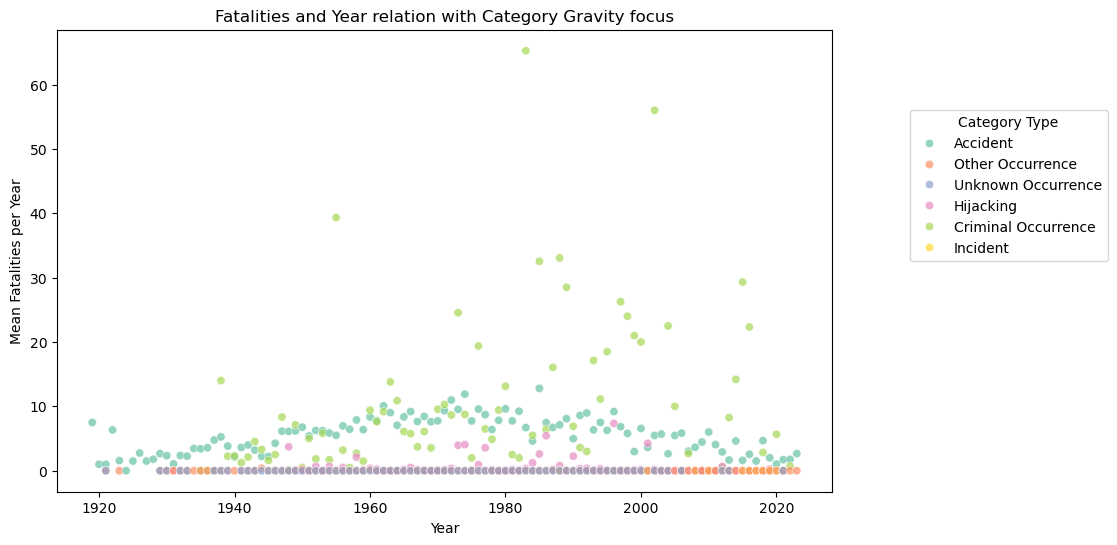

In [117]:
plt.figure(figsize=(10,6))

sns.scatterplot(data=cat_over_time_2, x='year', y='mean_fatalities', hue='cat_type', alpha=.7)
plt.title('Fatalities and Year relation with Category Gravity focus', )
plt.xlabel('Year')
plt.ylabel('Mean Fatalities per Year')
plt.legend(loc=(1.1,0.5), title='Category Type')

plt.show()

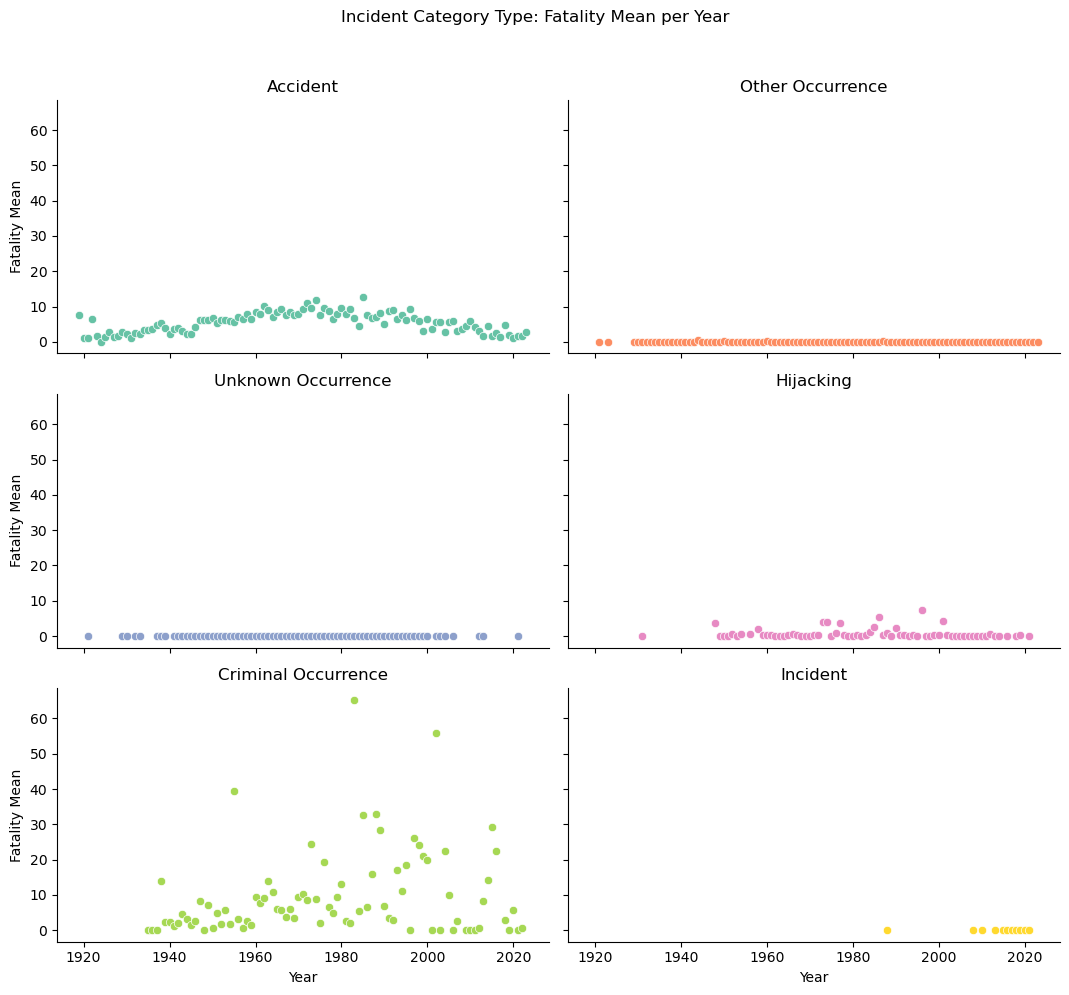

In [129]:
cat_4 = sns.FacetGrid(cat_over_time_2, col='cat_type', hue='cat_type', col_wrap=2, height=3, aspect=1.8)

cat_4.map(sns.scatterplot, 'year', 'mean_fatalities')

cat_4.set_axis_labels('Year', 'Fatality Mean')
cat_4.set_titles(col_template='{col_name}', size=12)
# cat_4.add_legend()

plt.subplots_adjust(top=1)
cat_4.fig.suptitle('Incident Category Type: Fatality Mean per Year', fontsize=12, y=1.1)

plt.show()

In [132]:
df.sort_values('fatalities', ascending=False).nlargest(10, 'fatalities')

,date,type,registration,operator,fatalities,location,country,cat,year,month,day,date_cleared,week_day,cat_type,cat_gravity
15484,12-AUG-1985,Boeing 747SR-46,JA8119,JAL,520.0,"near Ueno Village, Ta...",Japan,A1,1985.0,8.0,12.0,1985-08-12,Monday,Accident,Hull-Loss
12694,03-MAR-1974,DC-10-10,TC-JAV,THY,346.0,Bois d'Ermenonville,France,A1,1974.0,3.0,3.0,1974-03-03,Sunday,Accident,Hull-Loss
13460,27-MAR-1977,Boeing 747-121,N736PA,Pan Am,335.0,Tenerife-Los Rod...,Spain,A1,1977.0,3.0,27.0,1977-03-27,Sunday,Accident,Hull-Loss
15454,23-JUN-1985,Boeing 747-237B,VT-EFO,Air-India,329.0,"near Cork, Ireland",Atlantic Ocean,C1,1985.0,6.0,23.0,1985-06-23,Sunday,Criminal Occurrence,Hull-Loss
18291,12-NOV-1996,Boeing 747-168B,HZ-AIH,Saudi Arabian,312.0,near Charki Dadri,India,A1,1996.0,11.0,12.0,1996-11-12,Tuesday,Accident,Hull-Loss
14364,19-AUG-1980,Lockheed L-1011 TriStar 200,HZ-AHK,Saudi Arabian,301.0,Riyadh Internati...,Saudi Arabia,A1,1980.0,8.0,19.0,1980-08-19,Tuesday,Accident,Hull-Loss
22145,17-JUL-2014,Boeing 777-2H6ER,9M-MRD,Malaysia Airlines,298.0,Hrabove,Ukraine,C1,2014.0,7.0,17.0,2014-07-17,Thursday,Criminal Occurrence,Hull-Loss
16114,03-JUL-1988,Airbus A300B2-203,EP-IBU,Iran Air,290.0,near Qeshm Island,Iran,C1,1988.0,7.0,3.0,1988-07-03,Sunday,Criminal Occurrence,Hull-Loss
19748,19-FEB-2003,Ilyushin Il-76MD,15-2280,Iranian Revolutionary Guard,275.0,near Kerman,Iran,A1,2003.0,2.0,19.0,2003-02-19,Wednesday,Accident,Hull-Loss
15073,01-SEP-1983,Boeing 747-230B,HL7442,KAL,269.0,near Sakhalinsk [Okho...,Pacific Ocean,C1,1983.0,9.0,1.0,1983-09-01,Thursday,Criminal Occurrence,Hull-Loss


Despite the fact that the "Accident" category has caused the greatest number of victims over time, it is the "Criminal Occurrence" category that has recorded the highest averages over time.

In [135]:
coutry_events = df.groupby('country').size().reset_index()
coutry_events.columns = ['country', 'count']

In [193]:
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"

world = gpd.read_file(url)

In [195]:
world['SOVEREIGNT'] = world['SOVEREIGNT'].replace('United States of America', 'USA')

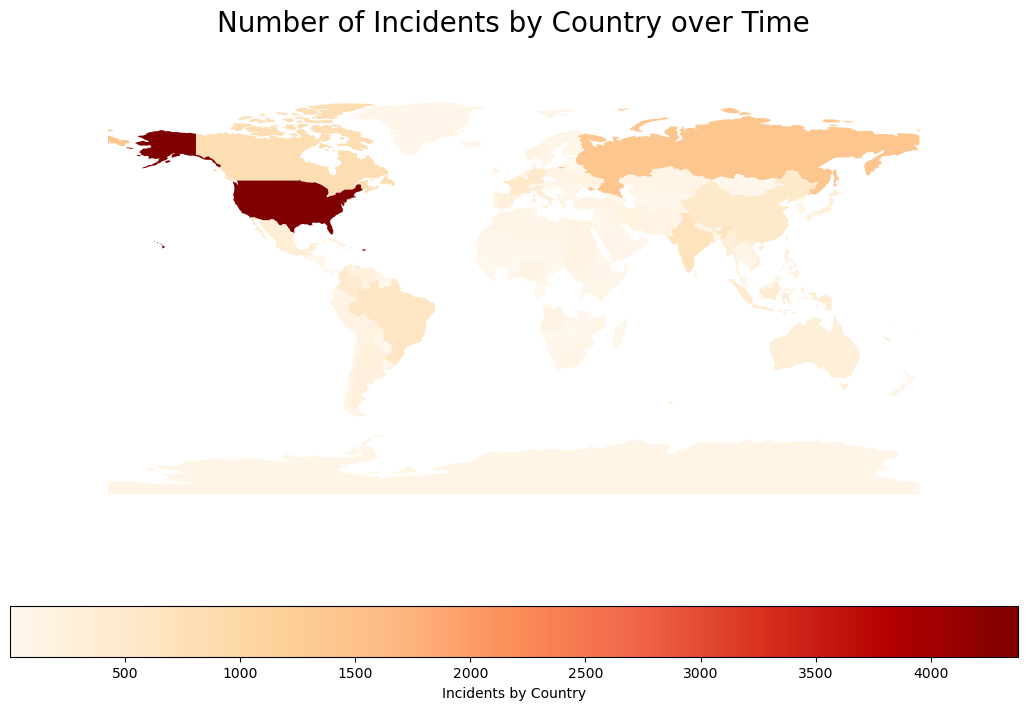

In [197]:
# Unisci i dati del tuo dataset con il geodataframe di world
merged = world.set_index('SOVEREIGNT').join(coutry_events.set_index('country'))

fig, ax = plt.subplots(1, 1, figsize=(13, 8))
merged.plot(column='count', ax=ax, legend=True,
            legend_kwds={'label': "Incidents by Country",
                         'orientation': "horizontal"},
            cmap='OrRd')
ax.set_axis_off()

plt.title('Number of Incidents by Country over Time', fontsize=20, y=1.1)

plt.show()